In [1]:
# get_ipython().magic('matplotlib notebook')
# get_ipython().magic('matplotlib inline')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
%matplotlib inline
%load_ext autoreload
%autoreload 2

#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy     as np
import xarray    as xr
import time      as clock
import warnings
xr.set_options(keep_attrs=True)
do_parallel   = False
parallel_nprc = 48   # number of dask workers
parallel_tmem = 200  # max. available RAM

/albedo/home/pscholz/tripyview


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [2]:
if do_parallel:
    from dask.distributed import Client
    # from dask.diagnostics import ProgressBar
    import dask
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client

In [3]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/dart_test/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= None #5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'hslice'

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'temp'
year      = [1979, 2019]
mon, day, record, box, depth = None, None, None, None, 1000

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/' # None #
ref_name  = None #'TKE, ck=0.1' # None
ref_year  = None #[1979, 2019]
ref_mon, ref_day, ref_record = None, None, None
ref_cstr, ref_cnum = 'wbgyr', 20
ref_cref, ref_crange, ref_cmin, ref_cmax, ref_cfac, ref_climit = None, None, None, None, None, None
ref_chist, ref_ctresh = True, 0.995
ref_rescale = None

#_____________________________________________________________________________________
do_clim   = True
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'

#_____________________________________________________________________________________
cstr, cnum = 'blue2red', 20
cref, crange, cmin, cmax, cfac, climit = None, None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncol      = 2        # number of pannel columns in figure
do_rescale= None #'log10'
which_dpi = 300
proj      = 'pc'
do_plot   = 'tcf'
do_reffig = True
figfac    = [8, 3.5] # [7, 3.5]

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (which_cycl != None) and (which_cycl != "None"): 
    for ii,ipath in enumerate(input_paths):
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])
    
    if (ref_path != None) and (ref_path != "None"): 
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)
        
#______________________________________________________________________________________________________
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path != None) and (ref_path != "None"): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
else:
    do_reffig=False
    
#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path != None) and (ref_path != "None"): 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths, ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


/albedo/home/pscholz/tripyview/tripyview/sub_mesh.py:139: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  mesh = pickle.load(fid)


In [5]:
data_list = list()
#___LOAD FESOM2 DATA___________________________________________________________________________________
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________
    yeari, moni, dayi, recordi = year, mon, day, record
    if (ii==0) and (ref_path != None and ref_path != 'None'): yeari, moni, dayi, recordi = ref_year, ref_mon, ref_day, ref_record
    
    #__________________________________________________________________________________________________
    if depth =='bottom':
        data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=yeari, mon=moni, day=dayi, record=recordi, 
                                    depth=None, descript=descript, do_info=False) 
        data = data.isel(nz=xr.DataArray(mesh.n_iz, dims='nod2'), nod2=xr.DataArray(range(0,mesh.n2dn), dims='nod2'))
    else:
        #______________________________________________________________________________________________
        if vname=='Kv*N2':
            data  = tpv.load_data_fesom2(mesh, datapath, vname='Kv', year=yeari, mon=moni, day=dayi, record=recordi, 
                                        depth=depth, descript=descript, do_info=False) 
            data2 = tpv.load_data_fesom2(mesh, datapath, vname='N2', year=yeari, mon=moni, day=dayi, record=recordi, 
                                        depth=depth, descript=descript, do_info=False) 
            data['Kv'].data = data['Kv'].data * data2['N2'].data
            data = data.rename(dict({'Kv':'Kv*N2'}))
            data['Kv*N2'].attrs['units'], data['Kv*N2'].attrs['description'], data['Kv*N2'].attrs['long_name'] =  '$m^2/s^3$', '(Kv)*(N^2)', '$\\overline{{Kv}} \\cdot \\overline{{N^2}}$'
            del(data2)
        #______________________________________________________________________________________________
        elif vname=='KvN2/N2':
            data  = tpv.load_data_fesom2(mesh, datapath, vname='KvN2' , year=yeari, mon=moni, day=dayi, record=recordi, 
                                        depth=depth, descript=descript, do_info=False)
            data2 = tpv.load_data_fesom2(mesh, datapath, vname='N2'   , year=yeari, mon=moni, day=dayi, record=recordi, 
                                        depth=depth, descript=descript, do_info=False)
            data['KvN2'].data = data['KvN2'].data / data2['N2'].data
            data  = data.rename(dict({'KvN2':'KvN2/N2'}))
            data['KvN2/N2'].attrs['units'], data['KvN2/N2'].attrs['description'], data['KvN2/N2'].attrs['long_name'] = '$m^2/s$', '(Kv*N)/N2', '$\\overline{{Kv \\cdot N^2}} / \\overline{{N^2}}$'
            del(data2) 
        #______________________________________________________________________________________________
        elif vname=='iwe_Tbot':    
            data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=yeari, mon=moni, day=dayi, record=recordi, 
                                        depth=None, descript=descript, do_info=False, do_nan=False) 
            data = data.isel(nz=xr.DataArray(mesh.n_iz, dims='nod2'), nod2=xr.DataArray(range(0,mesh.n2dn), dims='nod2'))
            data = data * xr.DataArray(mesh.zlev[mesh.n_iz-1]-mesh.zlev[mesh.n_iz], dims='nod2') * 1030 * 0.5
            # compute global value of total energy input in TW
            aux  = data['iwe_Tbot'].copy()*xr.DataArray(mesh.n_area, dims='nod2')*1.0e-12
            data['iwe_Tbot'].attrs['descript'] = '{:s}, $E_{{tot}}$={:2.3f} TW'.format(data['iwe_Tbot'].attrs['descript'], aux.sum(dim='nod2').data)
        #______________________________________________________________________________________________
        elif vname=='EKE':
            data  = tpv.load_data_fesom2(mesh, datapath, vname='ke_Umean', year=yeari, mon=moni, day=dayi, record=recordi, 
                                        depth=depth, descript=descript, do_info=True, do_ie2n=False) 
            datau2 = tpv.load_data_fesom2(mesh, datapath, vname='ke_U2mean', year=yeari, mon=moni, day=dayi, record=recordi, 
                                        depth=depth, descript=descript, do_info=True, do_ie2n=False) 
            data['ke_Umean'].data = datau2['ke_U2mean'].data/2 - (data['ke_Umean'].data**2)/2
            
            datau  = tpv.load_data_fesom2(mesh, datapath, vname='ke_Vmean', year=yeari, mon=moni, day=dayi, record=recordi, 
                                        depth=depth, descript=descript, do_info=True, do_ie2n=False) 
            datau2 = tpv.load_data_fesom2(mesh, datapath, vname='ke_V2mean', year=yeari, mon=moni, day=dayi, record=recordi, 
                                        depth=depth, descript=descript, do_info=True, do_ie2n=False)   
            data['ke_Umean'].data = data['ke_Umean'].data + datau2['ke_V2mean'].data/2 - (datau['ke_Vmean'].data**2)/2
                                
            data = data.rename(dict({'ke_Umean':'EKE'}))
            data['EKE'].attrs['units'], data['EKE'].attrs['description'], data['EKE'].attrs['long_name'] =  '$m^2/s^2$', 'EKE', 'Eddy Kinetic Energy'
            del(datau, datau2)
        #______________________________________________________________________________________________    
        else:
            data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=yeari, mon=moni, day=dayi, record=recordi, 
                                        depth=depth, descript=descript, do_info=False)
            
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    print('')
        
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    
    #__________________________________________________________________________________________________    
    # create reference data if given 
    if (ii==0) and (ref_path != None and ref_path != 'None'):
        data_ref = data
        if do_reffig: data_list.append(data_ref) 
        continue
        
    #__________________________________________________________________________________________________    
    # compute anomaly 
    if (ref_path != None and ref_path != 'None'):
        data_list.append(tpv.do_anomaly(data, data_ref))  
    # compute absolute    
    else:
        data_list.append(data)  
    del(data)
if (ref_path != None and ref_path != 'None'): del(data_ref)    
    
    
#___APPEND ABS CLIMATOLOGY_____________________________________________________________________________    
if (vname in ['temp', 'salt', 'pdens'] or 'sigma' in vname) and (depth != 'bottom') and do_clim and (ref_path is None): 
    ts = clock.time()
    clim_vname = vname
    if   vname=='temp' and  which_clim.lower()=='woa18': clim_vname = 't00an1'
    elif vname=='salt' and  which_clim.lower()=='woa18': clim_vname = 's00an1'
    clim = tpv.load_climatology(mesh, clim_path, clim_vname, depth=depth)
    print(' --> elasped time to load clim: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> clim uses {:3.2f} Gb:'.format(clim.nbytes/(1024**3)))
    data_list.append(clim)    
    del(clim)

0 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
 --> elasped time to load data: 0.31 min.
 --> data uses 0.00 Gb:

 --> elasped time to load clim: 0.01 min.
 --> clim uses 0.00 Gb:


--> histo: cmin, cmax =  0.38983509007422984 7.17347635856273
--> histo: cmin, cmax =  -0.40529149770736694 12.760963439941406
{'cstr': 'blue2red', 'cnum': 20, 'chist': True, 'ctresh': 0.995, 'cmin': -0.41, 'cmax': 12.76, 'cref': 6.0, 'cmap': <matplotlib.colors.ListedColormap object at 0x154e4ad24c10>, 'clevel': array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,
        5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ,
       10.5, 11. , 11.5, 12. , 12.5, 13. ])}


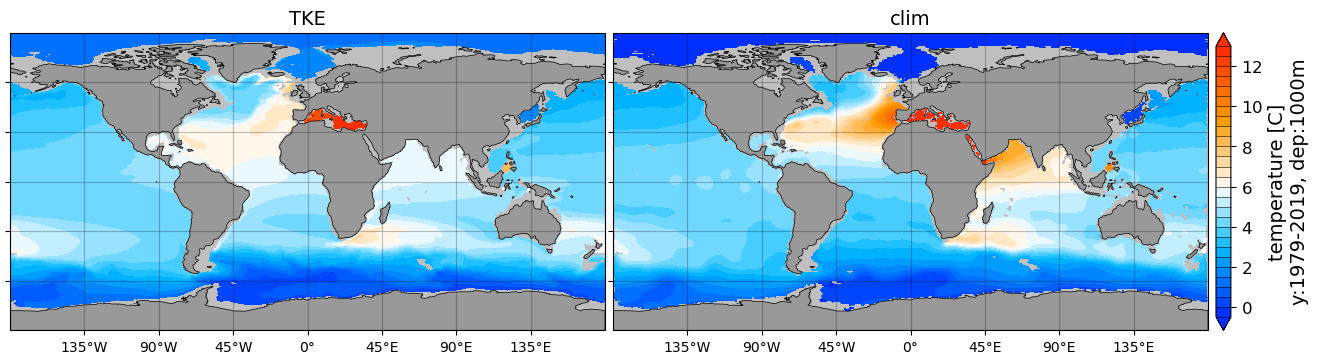

In [6]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = vname
slabel = data_list[0][sname].attrs['str_lsave']
if spath != None: spath  = os.path.join(spath,'{}_{}_{}.png'.format(which_mode, sname, slabel)) 
ncol   = np.min([ncol,len(data_list)])    
nrow   = np.ceil(len(data_list)/ncol).astype('int')
if save_fname != None: spath = save_fname

pos_gap = [0.005, 0.04]
if   proj in ['nps, sps']:pos_gap = [0.005, 0.035] 
elif proj in ['rob']     :pos_gap = [0.005, -0.02] 
# cinfo = dict({'cstr':'wbgyr', 'crange':[0, 5, 2.5]})
cinfo2 = cinfo.copy()
fig, ax, cbar = tpv.plot_hslice(mesh, data_list, cinfo=cinfo2, box=box, n_rc=[nrow, ncol], 
                            figsize=[ncol*figfac[0], nrow*figfac[1]], proj = proj, do_plot = do_plot,
                            do_lsmask='fesom', do_rescale=do_rescale, title='descript', 
                            do_reffig=do_reffig, ref_cinfo=ref_cinfo, ref_rescale=ref_rescale, 
                            pos_gap=pos_gap, pos_extend=[0.05, 0.05, 0.85, 0.90], 
                            do_save=spath, save_dpi=which_dpi)